In [2]:
!pip install imbalanced-learn &> /dev/null
!pip install smote-variants &> /dev/null

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer
## Will delete if not req
from numpy import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

##used to ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Almabetter learning/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv")
print("Dataset size")
print("Rows {} Columns {}".format(data.shape[0], data.shape[1]))

Dataset size
Rows 3390 Columns 17


In [6]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1235,1235,59,1.0,F,NO,0.0,0.0,0,0,0,205.0,142.5,74.5,25.63,85.0,83.0,0
2511,2511,47,1.0,F,YES,43.0,0.0,0,0,0,252.0,132.5,85.0,20.05,72.0,80.0,0
83,83,51,1.0,F,NO,0.0,0.0,0,0,0,226.0,105.0,71.0,27.73,68.0,79.0,0
3240,3240,58,4.0,M,NO,0.0,0.0,0,1,0,320.0,139.0,81.5,23.65,80.0,82.0,1
117,117,45,2.0,M,NO,0.0,0.0,0,0,0,232.0,122.5,82.5,27.55,74.0,59.0,1


In [7]:
# Id dropped as not req
data.drop(columns=['id'],inplace=True)

Data Analysis

In [8]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [9]:
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

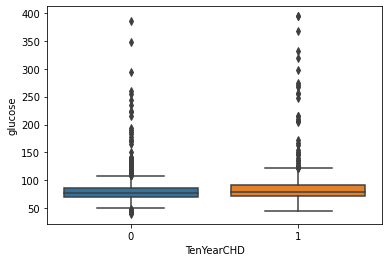

In [10]:
sns.boxplot(data=data,x='TenYearCHD',y='glucose');

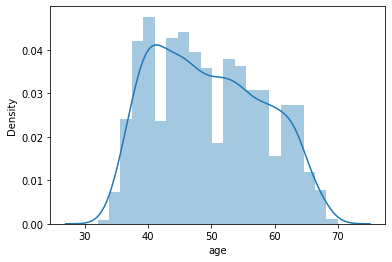

In [11]:
sns.distplot(data['age']);

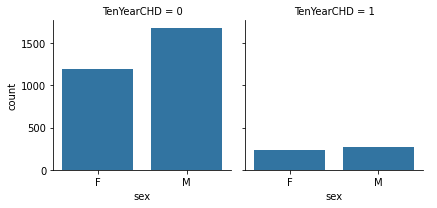

In [12]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

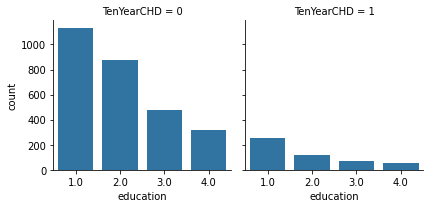

In [13]:

fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'education').add_legend()
# show the object
plt.show()

In [14]:
data['education'].describe()

count    3303.000000
mean        1.970936
std         1.019081
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: education, dtype: float64

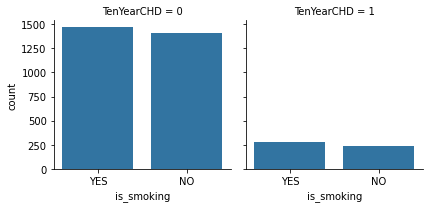

In [15]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'is_smoking').add_legend()
# show the object
plt.show()

In [16]:
data['prevalentStroke'].describe()

count    3390.000000
mean        0.006490
std         0.080309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prevalentStroke, dtype: float64

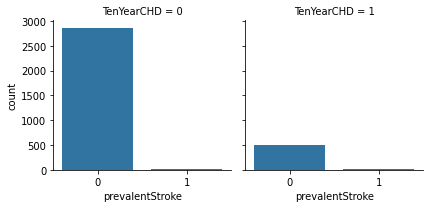

In [17]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'prevalentStroke').add_legend()
# show the object
plt.show()

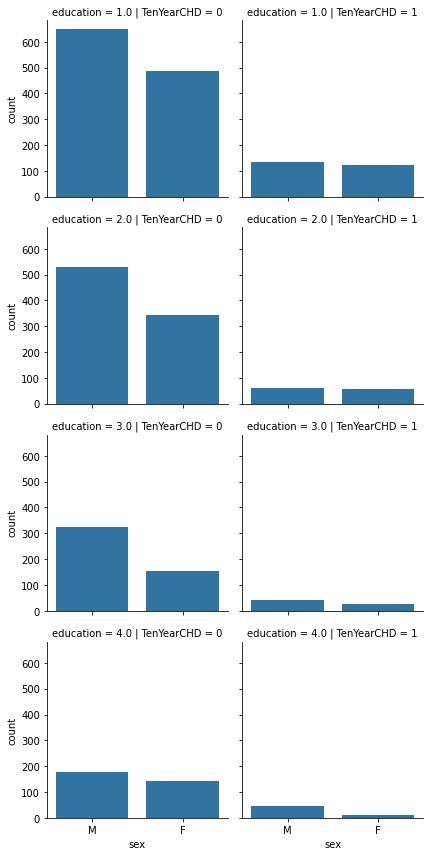

In [18]:
fct=sns.FacetGrid(data=data,col='TenYearCHD',row='education')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

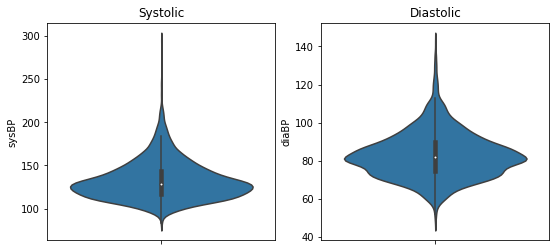

In [19]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.violinplot(data=data,y='sysBP')
plt.title("Systolic")
plt.subplot(1,2,2)
sns.violinplot(data=data,y='diaBP',)
plt.title("Diastolic")
#plt.legends()
plt.show()

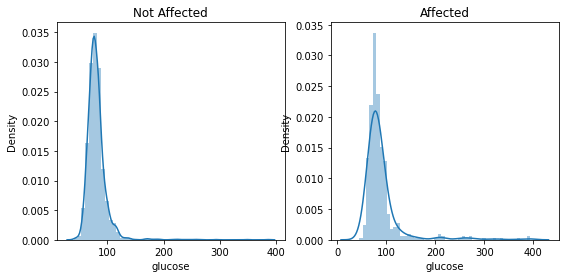

In [20]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['glucose']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['glucose']);
plt.title("Affected")
#plt.legends()
plt.show()

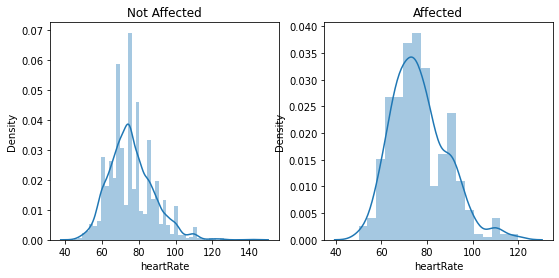

In [21]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['heartRate']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['heartRate']);
plt.title("Affected")
#plt.legends()
plt.show()

Handling Null Values

In [22]:
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

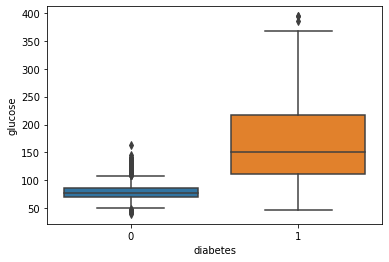

In [23]:
sns.boxplot(data=data,x='diabetes',y='glucose');

In [24]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

In [25]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

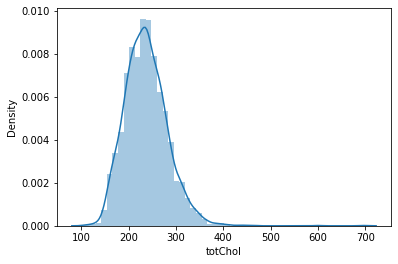

In [26]:
sns.distplot(data['totChol']);

In [27]:
# Less than 400 almost Normal, impute with mean
data['totChol']=data['totChol'].fillna(data['totChol'].median())

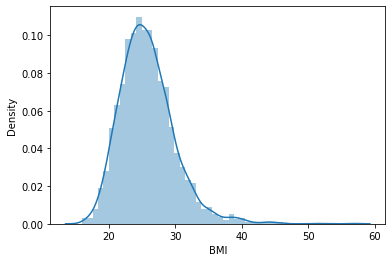

In [28]:
sns.distplot(data['BMI']);

In [29]:
# Less than 36 almost Normal, impute with mean
data['BMI']=data['BMI'].fillna(data['BMI'].median())

In [30]:
## CigsPerDay 22 nulls needs imputation as is_smoking is yes all 22 records
data[(data.cigsPerDay.isna()) & (data.is_smoking!='YES')]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


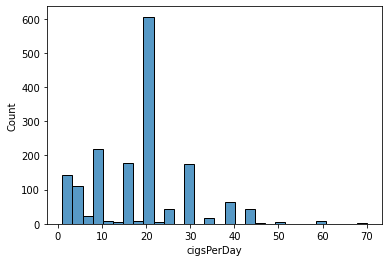

In [31]:
#data['cigsPerDay'].value_counts()

sns.histplot(data[data['cigsPerDay']!=0]['cigsPerDay'],bins=30);
## Bar plot gives an idea about what count of cigsperday is observed in more numbers

In [32]:
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))

In [33]:
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))

In [34]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [35]:
# Encoding this categorical to prepare data for KNN impute
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [36]:
#data.drop(['glucose'],inplace=True,axis=1)

In [37]:
data.isna().sum()

age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [38]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [39]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [40]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [41]:
data_trans.isna().sum().sum()

0

In [42]:
data=data_trans.copy()

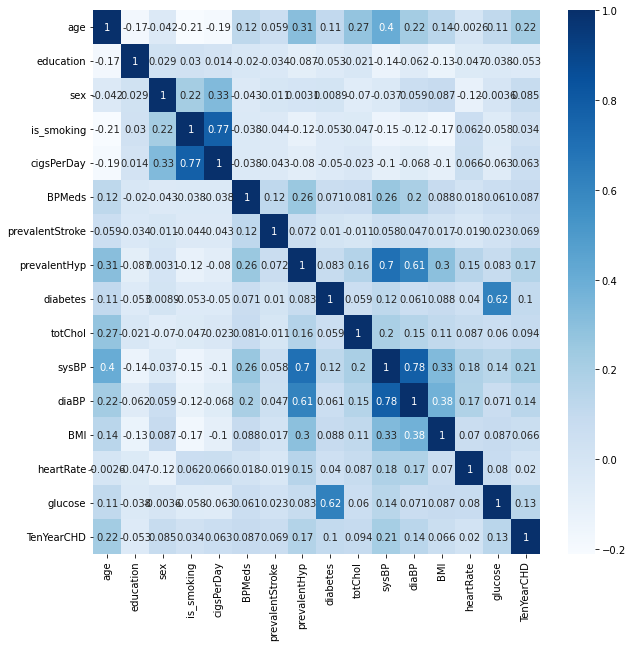

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,cmap='Blues');

In [44]:

X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [45]:
# handling data imbalance
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-25 09:37:20,139:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [46]:
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

In [47]:
X=data_new.drop(['TenYearCHD'],axis=1)
y=data_new['TenYearCHD']

In [48]:
#X.drop(['is_smoking','education'],axis=1,inplace=True)

In [49]:
X['pulse']=X['sysBP']-X['diaBP']
X.drop(['sysBP','diaBP'],axis=1,inplace=True)

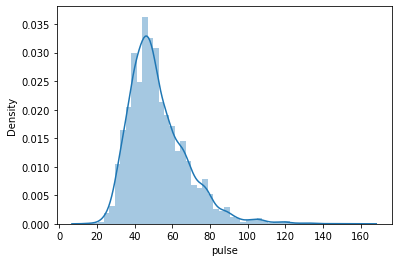

In [50]:
sns.distplot(X['pulse'])

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [52]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [53]:
## Define the logistic model
logistic = LogisticRegression(random_state=30)

In [54]:
scoring = ['roc_auc']
scores = cross_validate(logistic,X, y, scoring = scoring, cv = 5, return_train_score=True,return_estimator=True,verbose = 10);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.711, test=0.702) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.716, test=0.687) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.708, test=0.717) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END ................. roc_auc: (train=0.705, test=0.713) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.710, test=0.718) total time=   0.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [56]:
logistic.fit(X_train,y_train)

LogisticRegression(random_state=30)

In [57]:
# Get the predicted class
train_preds = logistic.predict(X_train)
test_preds = logistic.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
print(cm)

[[482 255]
 [220 483]]


In [58]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds)
print(roc_auc)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
print("Precision")
print(precision)
print("Recall")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.6705290951166836
Precision
0.6544715447154471
Recall
0.6870554765291608
F1-Score
0.6703678001387924


In [59]:
# Get the predicted probabilities
train_preds = logistic.predict_proba(X_train)
test_preds = logistic.predict_proba(X_test)

train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

Best Threshold=0.507997, G-Mean=0.681
  


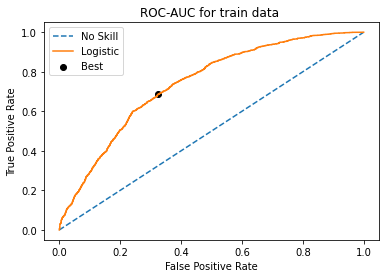

In [60]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print("  ")
plt.title("ROC-AUC for train data ")
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')# marker='.'
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [61]:
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))

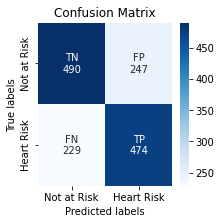

In [62]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
#cm = confusion_matrix(y_test, test_preds_new)
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [63]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print("\n")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.6695553655490812
0.6574202496532594


0.6742532005689901
F1-Score
0.6657303370786517


Tuning the logistic model

In [64]:
grid={
'C':[100, 10, 5,1.0, 0.1, 0.01],
'penalty':['none', 'l1', 'l2', 'elasticnet'],
'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
}
logistic = LogisticRegression(random_state=10)

In [65]:

grid_search = GridSearchCV(estimator=logistic, param_grid=grid, n_jobs=-1, scoring='roc_auc',cv=5,error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [66]:
# import sklearn
# print(sorted(sklearn.metrics.SCORERS.keys()))

In [67]:
C=grid_result.best_params_['C']
penalty=grid_result.best_params_['penalty']
solver=grid_result.best_params_['solver']
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [68]:
tuned_logistic=LogisticRegression(C=C, penalty=penalty,solver=solver,random_state=1)
tuned_logistic.fit(X_train,y_train)

LogisticRegression(C=0.01, random_state=1, solver='newton-cg')

In [69]:
# Get the predicted probabilities
train_preds = tuned_logistic.predict(X_train)
test_preds = tuned_logistic.predict(X_test)

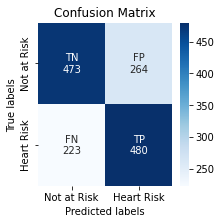

In [70]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [71]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
print("")

precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print("Precision")
print(precision)
print("Recall")
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.6695553655490812

Precision
0.6574202496532594
Recall
0.6742532005689901
0.6657303370786517

0.6694444444444444


# Support Vector Classifier

In [72]:
clf = SVC(kernel='rbf', C=1E6,random_state=1)
clf.fit(X_train, y_train)

SVC(C=1000000.0, random_state=1)

In [73]:
y_pred_svc=clf.predict(X_test)

In [74]:
cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

[[595 142]
 [ 92 611]]


In [75]:
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, y_pred_svc)
print(accuracy)

0.8114209827357237
0.8691322901849218
0.8392857142857143

0.8375


In [76]:
clf = SVC(kernel='rbf', C=1E6,random_state=1,probability=True)
clf.fit(X_train, y_train)

SVC(C=1000000.0, probability=True, random_state=1)

In [77]:
train_preds=clf.predict_proba(X_train)
test_preds=clf.predict_proba(X_test)

In [78]:
## Calc threshold from training data
train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

## For test data
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

In [79]:
train_preds

array([9.99999921e-01, 9.99999753e-01, 3.70278783e-04, ...,
       2.01284432e-05, 9.99999974e-01, 1.15214335e-01])

Best Threshold=0.506348, G-Mean=1.000


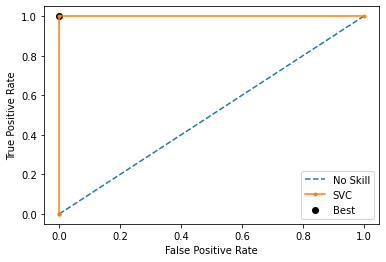

In [80]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='SVC' , marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [81]:
train_preds_new=np.array(train_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))

[Text(0, 0.5, 'Not at Risk'), Text(0, 1.5, 'Heart Risk')]

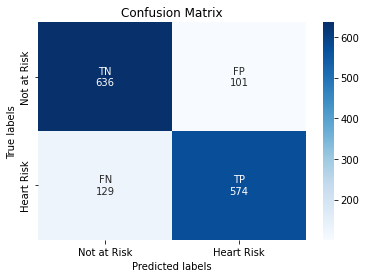

In [82]:
# Get the confusion matrix for test

labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [83]:
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.8503703703703703
0.8165007112375533
0.8330914368650217

0.8402777777777778


In [84]:
train_preds_class=clf.predict(X_train)
test_preds_class=clf.predict(X_test)
cm = confusion_matrix(y_test, test_preds_class)
cm

array([[595, 142],
       [ 92, 611]])

In [85]:
precision = precision_score(y_test, test_preds_class)
recall = recall_score(y_test, test_preds_class)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_class)
print(accuracy)

0.8114209827357237
0.8691322901849218
0.8392857142857143

0.8375


# Bagging Classifier

In [86]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [50, 100,500, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.945477 using {'n_estimators': 1000}
0.943809 (0.004731) with: {'n_estimators': 50}
0.944194 (0.003891) with: {'n_estimators': 100}
0.945360 (0.004714) with: {'n_estimators': 500}
0.945477 (0.004014) with: {'n_estimators': 1000}


In [87]:
grid_result.best_params_

{'n_estimators': 1000}

In [88]:
clf_bag=BaggingClassifier(n_estimators=grid_result.best_params_['n_estimators'],random_state=10).fit(X_train,y_train)
y_pred_bag=clf_bag.predict(X_test)

In [89]:
cm = confusion_matrix(y_test, y_pred_bag)
print(cm)

[[720  17]
 [113 590]]


In [90]:
precision = precision_score(y_test, y_pred_bag)
recall = recall_score(y_test, y_pred_bag)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag)
print(accuracy)

Precision: 0.972
Recall: 0.839
F1-Score 0.901
0.9097222222222222


Bagging with Logistic

In [91]:
base1 = LogisticRegression(random_state=10)


In [92]:
clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,oob_score=True).fit(X_train,y_train)
#clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,warm_start=True).fit(X_train,y_train)
y_pred_bag1=clf_bag_log1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_bag1)
print(cm)

## Metrics
precision = precision_score(y_test, y_pred_bag1)
recall = recall_score(y_test, y_pred_bag1)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag1)
print(accuracy)

[[476 261]
 [229 474]]
Precision: 0.645
Recall: 0.674
F1-Score 0.659
0.6597222222222222


In [93]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:

clf_adb = AdaBoostClassifier(random_state=1)
clf_adb.fit(X_train, y_train)

#############
y_pred_adb=clf_adb.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb)
recall = recall_score(y_test, y_pred_adb)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb)
print(accuracy)


Precision: 0.973
Recall: 0.832
F1-Score 0.897
0.9069444444444444


In [95]:
clf_adb.n_estimators

50

In [96]:
clf_adb.feature_importances_

array([0.08, 0.24, 0.22, 0.08, 0.06, 0.04, 0.02, 0.1 , 0.  , 0.04, 0.02,
       0.02, 0.02, 0.06])

In [100]:
# define models and parameters
model = AdaBoostClassifier(random_state=1)
n_estimators = [10,50, 100,200,500, 800,1000]
# define grid search
grid = dict(n_estimators=n_estimators)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.898268 using {'n_estimators': 100}
0.870786 (0.011493) with: {'n_estimators': 10}
0.897143 (0.007774) with: {'n_estimators': 50}
0.898268 (0.008733) with: {'n_estimators': 100}
0.896853 (0.009922) with: {'n_estimators': 200}
0.894434 (0.010099) with: {'n_estimators': 500}
0.892781 (0.009685) with: {'n_estimators': 800}
0.891652 (0.007892) with: {'n_estimators': 1000}


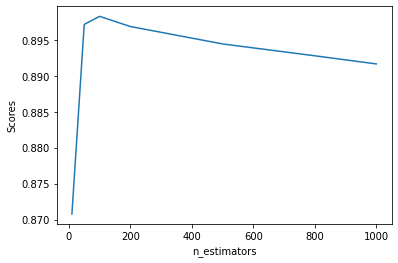

In [101]:
means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['param_n_estimators']
df_scores=pd.DataFrame(zip(means, params),columns=['Scores','n_estimators'])

#plt.ylim(0, 20)
#plt.xlim(10, None)
sns.lineplot(data=df_scores,y='Scores',x='n_estimators',markers='True');

# Gaussian NB

In [158]:
var_smoothing_vals=np.arange(0.01,0.1,0.005)
learning_rate_vals=np.arange(0.05,0.9,0.05)

prec_list=[]
rec_list=[]
f1_list=[]
acc_list=[]
itrs_list=[]
for i in var_smoothing_vals:
  for j in learning_rate_vals:
    #print ("For var_smoothing={:.3f} and learning_rate={:.3f}".format(i,j))
    itrs_list.append("smoothing={:.3f},learn_rate={:.3f}".format(i,j))
    clf_adb_NB = AdaBoostClassifier(random_state=1,base_estimator=GaussianNB(var_smoothing=i),learning_rate=j)
    clf_adb_NB.fit(X_train, y_train)
    # #############
    y_pred_adb_NB_train=clf_adb_NB.predict(X_train)
    ## Metrics
    precision = precision_score(y_train, y_pred_adb_NB_train)
    recall = recall_score(y_train, y_pred_adb_NB_train)
    prec_list.append(precision)
    rec_list.append(recall)
    #print("Precision: {:.3f}".format(precision))
    #print("Recall: {:.3f}".format(recall))
    f1=2*precision*recall/(recall+precision)
    #print ("F1-Score {:.3f}".format(f1)
    f1_list.append(f1)
    accuracy =accuracy_score(y_train, y_pred_adb_NB_train)
    acc_list.append(accuracy)
    #print("Accuracy {:.3f}".format(accuracy))

scores_comp_adb_nb=pd.DataFrame(zip(prec_list,rec_list,f1_list,acc_list),columns=['Precision','Recall','F1','Accuracy'],index=itrs_list)

In [127]:
f1_mx=max(scores_comp_adb_nb['F1'])
acc_max=max(scores_comp_adb_nb['Accuracy'])
scores_comp_adb_nb[(scores_comp_adb_nb['F1']==f1_mx) | (scores_comp_adb_nb['Accuracy']==acc_max)  ]

,Precision,Recall,F1,Accuracy
"smoothing=0.070,learn_rate=0.100",0.759791,0.802390,0.780510,0.77258
"smoothing=0.080,learn_rate=0.100",0.758442,0.805147,0.781097,0.77258
"smoothing=0.085,learn_rate=0.100",0.758218,0.805607,0.781194,0.77258


In [159]:

clf_adb_NB = AdaBoostClassifier(random_state=1,base_estimator=GaussianNB(var_smoothing=0.085),learning_rate=0.1)
clf_adb_NB.fit(X_train, y_train)

# #############
y_pred_adb_NB=clf_adb_NB.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb_NB)
recall = recall_score(y_test, y_pred_adb_NB)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb_NB)
print("Accuracy {:.3f}".format(accuracy))


Precision: 0.743
Recall: 0.797
F1-Score 0.769
Accuracy 0.766


In [160]:
# Adaboost NB tuned
cm = confusion_matrix(y_test, y_pred_adb_NB)
print(cm)

[[543 194]
 [143 560]]


In [142]:

clf_adb_svc = AdaBoostClassifier(random_state=1,base_estimator=SVC(kernel='rbf', C=1E6,random_state=1,probability=True),learning_rate=0.05,n_estimators=10)
clf_adb_svc.fit(X_train, y_train)

# #############
y_pred_adb_svc=clf_adb_svc.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb_svc)
recall = recall_score(y_test, y_pred_adb_svc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb_svc)
print(accuracy)

# Adaboost SVC tuned
cm = confusion_matrix(y_test, y_pred_adb_svc)
print(cm)


Precision: 0.898
Recall: 0.836
F1-Score 0.866
0.8736111111111111
[[670  67]
 [115 588]]


In [164]:
!pip install CatBoost>> /dev/null

In [165]:
from catboost import CatBoostClassifier


In [168]:
#model = CatBoostClassifier()
clf_cat = CatBoostClassifier(random_state=1,verbose=False)
clf_cat.fit(X_train, y_train)

# #############
y_pred_cat=clf_cat.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_cat)
print(accuracy)

# Adaboost SVC tuned
cm = confusion_matrix(y_test, y_pred_cat)
print(cm)


Precision: 0.972
Recall: 0.828
F1-Score 0.894
0.9041666666666667
[[720  17]
 [121 582]]
